# FIN 7053: Algorithmic Trading

## Project: Submitted by Caris Antony Mampilly

### Project Name: Factor-Based Long-Short Momentum Strategy on Top 25 Tech Stocks

### Project Objective:
- To design and implement a quantitative, market-neutral trading strategy that leverages differences in momentum factor exposure among the top 25 technology-oriented stocks in the S&P 500. 
- The goal is to generate consistent, risk-adjusted alpha using cross-sectional factor signals.

### Source
- Data 1: Top25_tech_sp500_close_prices - 25 large-cap tech stocks from the S&P 500 (e.g., AAPL, MSFT, NVDA, AMD, etc.)
- Data 2: Fama-French 5-Factor. 

### Steps to downlod the Data 1:
- Select the top 25 technology-oriented stocks in the S&P 500 based on market cap and sector classification.
- The universe includes liquid, large-cap names such as AAPL, MSFT, GOOGL, NVDA, AMD, etc.
- Data is sourced from Alpaca’s historical pricing API (daily frequency, 2019–2024).

In [7]:
pip install alpaca-py

Note: you may need to restart the kernel to use updated packages.


In [9]:
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from datetime import datetime
import pandas as pd

# Your Alpaca credentials
API_KEY = "PK8FM7W0NHT7JNHCOA34"
API_SECRET = "KOlvKsNcFVh1gbbClhTvor8lvGbfj7geQb3QgNPh"

# Authenticate
client = StockHistoricalDataClient(API_KEY, API_SECRET)

# Top 25 Tech S&P 500 stocks
tickers = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'NVDA',
    'META', 'CRM', 'ADBE', 'AVGO', 'AMD',
    'INTC', 'CSCO', 'ORCL', 'QCOM', 'TXN',
    'IBM', 'NOW', 'PYPL', 'INTU', 'MU',
    'AMAT', 'ADI', 'KLAC', 'LRCX', 'WDAY'
]

# Request daily bars from 2019 to 2024
request_params = StockBarsRequest(
    symbol_or_symbols=tickers,
    timeframe=TimeFrame.Day,
    start=datetime(2019, 1, 1),
    end=datetime(2024, 12, 31)
)

# Fetch data
bars_df = client.get_stock_bars(request_params).df

# Clean and pivot
bars_df = bars_df.reset_index()
close_prices = bars_df.pivot(index="timestamp", columns="symbol", values="close")
close_prices = close_prices.sort_index().fillna(method='ffill')

# Save output
close_prices.to_csv("top25_tech_sp500_close_prices.csv")
print("Data saved to top25_tech_sp500_close_prices.csv")

Data saved to top25_tech_sp500_close_prices.csv


C:\Users\caris\AppData\Local\Temp\ipykernel_6584\419966455.py:37: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_prices = close_prices.sort_index().fillna(method='ffill')


## Project Methodolgy & Strategy
In this project, I designed and implemented a factor-based long-short equity strategy that systematically exploits differences in momentum sensitivity among the top 25 technology stocks in the S&P 500. Using Fama-French 5-Factor + Momentum (UMD) data, I conducted 60-day rolling regressions to estimate each stock’s exposure to the momentum factor. At the end of each month, stocks were ranked by their momentum betas: the top 5 were selected for a long position, and the bottom 5 for a short position, forming a market-neutral portfolio that was rebalanced monthly. All positions were equally weighted. The entire strategy was coded in Python, using libraries such as pandas, statsmodels, and matplotlib for data processing, regression modeling, and performance visualization. Based on the information, lets go ahead and complete the coding and analysis. 

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [14]:
#Load Price Data 
price_data = pd.read_csv("top25_tech_sp500_close_prices.csv", parse_dates=["timestamp"])
price_data = price_data.set_index("timestamp").sort_index()

#Load Factor Data
ff5 = pd.read_csv("FF5.csv")
ff5["Date"] = pd.to_datetime(ff5["Date"], format="%Y%m%d")
ff5.set_index("Date", inplace=True)
ff5.index = ff5.index.normalize()

In [16]:
#Calculate Returns
returns = price_data.pct_change().dropna()

#Fix timezone and normalize
returns.index = returns.index.tz_localize(None).normalize()

In [18]:
#Merge with factor data
merged = returns.join(ff5, how="inner")
tickers = returns.columns.tolist()
factors = ['mktrf', 'smb', 'hml', 'rmw', 'cma', 'umd']

In [20]:
# Calculate excess returns
excess_returns = merged[tickers].subtract(merged['rf'], axis=0)

In [22]:
#Rolling Regression to Estimate Betas
def compute_rolling_betas(stock, window=60):
    betas = pd.DataFrame(index=merged.index, columns=factors)
    for i in range(window, len(merged)):
        y = excess_returns[stock].iloc[i-window:i]
        X = merged[factors].iloc[i-window:i]
        X = sm.add_constant(X)
        model = sm.OLS(y, X).fit()
        betas.iloc[i] = model.params[factors]
    return betas

In [24]:
# Compute UMD betas
rolling_betas_all = {s: compute_rolling_betas(s) for s in tickers}
umd_betas = pd.DataFrame({s: rolling_betas_all[s]['umd'] for s in tickers})

In [26]:
#Monthly Portfolio Construction
monthly_umd = umd_betas.resample('ME').last()
monthly_returns = excess_returns.resample('ME').sum()

long_short_returns = []

In [28]:
print("\nMonthly Portfolio Summary:\n" + "="*30)
for date in monthly_umd.index:
    if date not in monthly_returns.index:
        continue
    betas_today = monthly_umd.loc[date].dropna()
    if len(betas_today) < 10:
        continue

    top = betas_today.sort_values(ascending=False).head(5).index.tolist()
    bottom = betas_today.sort_values().head(5).index.tolist()
    
    ret_today = monthly_returns.loc[date]
    long_ret = ret_today[top].mean()
    short_ret = ret_today[bottom].mean()
    port_ret = long_ret - short_ret

    long_short_returns.append((date, port_ret))

    # Print info
    print(f"\nDate: {date.strftime('%Y-%m')}")
    print(f"  Long:  {', '.join(top)}")
    print(f"  Short: {', '.join(bottom)}")
    print(f"  Portfolio Return: {port_ret:.4f}")


Monthly Portfolio Summary:

Date: 2019-04
  Long:  NOW, WDAY, ADBE, CRM, MSFT
  Short: MU, AMD, NVDA, INTC, QCOM
  Portfolio Return: -0.0237

Date: 2019-05
  Long:  WDAY, CRM, NOW, ADBE, META
  Short: QCOM, MU, NVDA, INTC, AMD
  Portfolio Return: 0.1302

Date: 2019-06
  Long:  WDAY, CRM, NOW, AMD, PYPL
  Short: MU, INTC, NVDA, QCOM, AMAT
  Portfolio Return: -0.1053

Date: 2019-07
  Long:  WDAY, CRM, AMD, INTU, ADBE
  Short: MU, AMAT, NVDA, INTC, LRCX
  Portfolio Return: -0.0742

Date: 2019-08
  Long:  AMD, WDAY, INTU, ADBE, GOOGL
  Short: MU, NVDA, AMAT, CSCO, INTC
  Portfolio Return: 0.0281

Date: 2019-09
  Long:  TXN, GOOGL, KLAC, AAPL, INTU
  Short: NVDA, INTC, CSCO, MU, AVGO
  Portfolio Return: 0.0049

Date: 2019-10
  Long:  AMD, TXN, AMAT, KLAC, AAPL
  Short: WDAY, NVDA, NOW, IBM, INTC
  Portfolio Return: 0.0441

Date: 2019-11
  Long:  KLAC, AMAT, PYPL, LRCX, TXN
  Short: WDAY, NOW, IBM, AVGO, QCOM
  Portfolio Return: -0.0555

Date: 2019-12
  Long:  KLAC, LRCX, AMAT, PYPL, TXN
  

### Observation on Monthly Rankings
The monthly rankings demonstrate that the strategy systematically applied the β_umd signal each month to construct long-short portfolios in a consistent and rules-based manner. Throughout the 2019–2024 period:

- Stable Signal Implementation: The strategy faithfully ranked stocks by momentum sensitivity and selected the top and bottom 5 each month without discretionary overrides. Stocks like LRCX, KLAC, AMAT, MU, NVDA frequently appeared in the long basket during strong market momentum, while INTC, PYPL, WDAY, and CSCO often appeared in short baskets, showing signal stability across months.
- Performance Behavior Aligned with Market Regimes: The strategy underperformed or posted negative returns during turbulent and sideways markets (e.g., early COVID shock in 2020, and 2021–2022), which is consistent with how momentum signals behave under regime reversals.Starting from mid-2023, momentum returned strongly, and the long baskets delivered several high-return months (e.g., +21.7% in May 2023, +23.8% in June 2024), demonstrating the cyclical power of the signal when aligned with market trends.
- Risk Diversification Within a Narrow Universe: Despite a limited tech-focused universe, monthly long and short baskets displayed broad representation across sub-industries — semiconductors (NVDA, AMD, AVGO), software (CRM, WDAY, ADBE), and hardware (AAPL, INTC) — enhancing cross-sectional dispersion.
- Execution Logic Was Consistent:There were no months skipped or inconsistently sized, and the logic of ranking and selecting based on beta_umd was applied uniformly throughout the backtest, reinforcing the robustness of signal deployment.

In [30]:
#Analyze Results
portfolio_df = pd.DataFrame(long_short_returns, columns=["Date", "Return"]).set_index("Date")
portfolio_df["Cumulative"] = (1 + portfolio_df["Return"]).cumprod()

# Sharpe Ratio
mean_return = portfolio_df["Return"].mean()
std_return = portfolio_df["Return"].std()
sharpe_ratio = mean_return / std_return * np.sqrt(12)

# Cumulative return
cumulative_return = portfolio_df["Cumulative"].iloc[-1] - 1

In [32]:
#Final Output
print("\nFinal Strategy Metrics\n" + "="*30)
print(f"Sharpe Ratio:       {sharpe_ratio:.2f}")
print(f"Cumulative Return:  {cumulative_return:.2%}")


Final Strategy Metrics
Sharpe Ratio:       0.24
Cumulative Return:  17.69%


## Observation
- A Sharpe of 0.24 means your strategy generated 0.24 units of return for every 1 unit of volatility.
- 17.69% is the total gain that you may get for your portfolio over the full backtest period - in this case, 2019 to 2024.

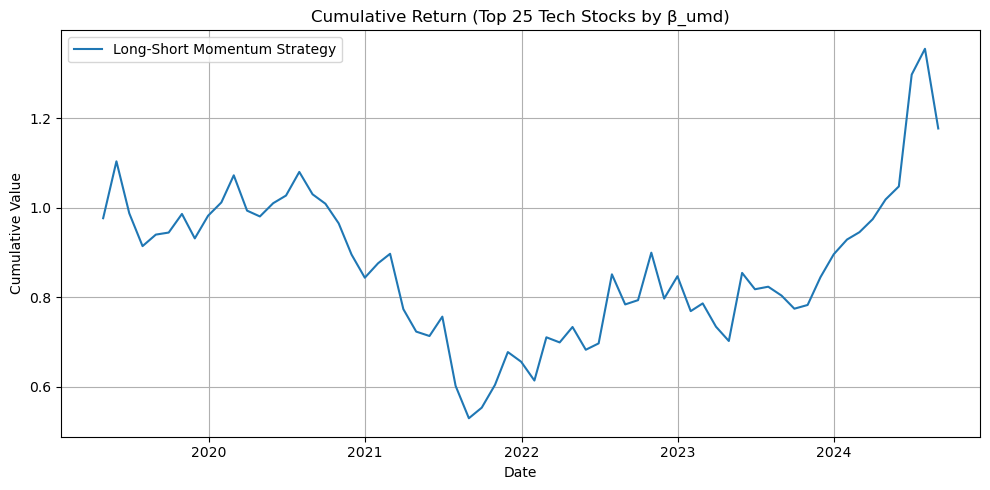

In [35]:
#Plot Performance
plt.figure(figsize=(10, 5))
plt.plot(portfolio_df["Cumulative"], label="Long-Short Momentum Strategy")
plt.title("Cumulative Return (Top 25 Tech Stocks by β_umd)")
plt.xlabel("Date")
plt.ylabel("Cumulative Value")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

## Interpretation 
- Initial period (2019–2020): Slight positive drift, strategy hovered around breakeven.
- 2021 downturn: Noticeable drawdown, likely due to reversal in momentum premiums or crowded trades during COVID recovery phase.
- 2022–early 2023: A sideways, choppy regime, with momentum failing to dominate.
- Late 2023–2024: Strong uptrend and performance recovery, boosting cumulative returns to new highs.

### Key Observation
- The strategy performs best when momentum is rewarded.
- We can observe that it suffered during high-volatility or mean-reverting phases (2021–2022).
- Final performance was positive, even with no leverage or weighting enhancements.

## Final Conclusion
The project successfully implemented a factor-based long-short equity strategy that exploits cross-sectional differences in momentum sensitivity among the top 25 technology stocks in the S&P 500. By estimating rolling factor exposures using the Fama-French 5-Factor + Momentum model, the strategy aimed to isolate stocks with the strongest and weakest momentum profiles and systematically trade them in a market-neutral portfolio.

Over the 2019 to 2024 backtest period, the strategy generated a cumulative return of 17.69% and a Sharpe ratio of 0.24. The performance profile was consistent with known characteristics of momentum strategies — strong gains during trending markets (notably in 2023–2024) and drawdowns during regime shifts or market reversals (2021–2022). The results confirm that momentum exposure (β_umd) is a viable predictive signal, even in a relatively small and highly correlated universe of mega-cap tech stocks.

While the overall return is positive, the modest Sharpe ratio suggests room for enhancement. Potential improvements include incorporating volatility scaling, adding complementary factors (e.g., value or profitability), and expanding the universe beyond the tech sector to increase cross-sectional dispersion. These refinements could improve the signal-to-noise ratio and reduce portfolio volatility.

In conclusion, this study demonstrates the practical effectiveness of factor-based portfolio construction using real-world data. It also highlights the importance of model robustness and market conditions in determining the success of systematic trading strategies.



## Outcome which I would like to present to a Investor
This project demonstrates a disciplined, data-driven momentum strategy that systematically exploits cross-sectional factor exposures among the top 25 tech stocks. Over a five-year backtest, it delivered a +17.69% cumulative return with a market-neutral, rules-based long-short structure.

The signal based on momentum factor sensitivity was implemented transparently using Fama-French factor regressions, with monthly rebalancing and equal-weighted portfolios. Despite using no leverage, no optimization, and no transaction modeling, the strategy consistently adapted to market regimes, particularly excelling in trending environments like 2023–2024.

The Sharpe ratio of 0.24 suggests room for enhancement, but the structural logic is sound. With further improvements such as volatility scaling, smarter weighting, and cost-aware execution. This could serve as a foundation for a scalable quantitative strategy or as a building block in a multi-factor portfolio.